# Transmision spectrum, time fit. 

The notations are rather succint, and the 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt

In [3]:
λ = np.arange(400,800,5)
λ0_g = 600
σ0_g = 20
A0_g = 0.8


let's define an absorbance function to help us:

In [4]:
def A(Amax, λc, σc):
    """
    Smart absorbtion function, Amax can be a function of time, or not.
    
    It will just behave accordingly.
    """
    if callable(Amax):
        return lambda λ,time:Amax(time)*exp(-((λ-λc)**2/σc**2))
    else:
        return lambda λ,time:Amax*exp(-((λ-λc)**2/σc**2))

let's create a generatime model  for or data. The _transmission_ is a function of various parameter:

 - wavelenght $\lambda_c$
 - Maximum absobtion Am
 - width of absorbtion peek, 
 - center of absortion peek $\lambda_c$
 - and time

In [5]:
T_g = lambda λ, Am, λc, σ, time: 1- A(Am, λc, σ)(λ, time)

Let's fix a few of these for now, with only the considered wavelenght as a variable parameter.

In [6]:
T_gs = lambda λ: T_g(λ, A0_g, λ0_g, σ0_g, 0)

Text(0,0.5,'Transmission (AU)')

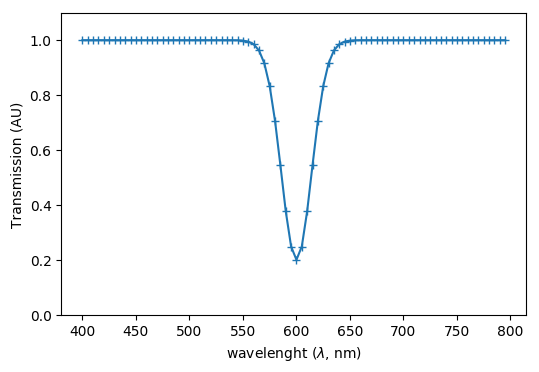

In [7]:
fig, ax = plt.subplots()
plt.plot(λ, T_gs(λ), marker='+')
ax.set_xlabel('wavelenght ($\lambda$, nm)')
ax.set_ylim(0,1.1)
ax.set_ylabel('Transmission (AU)')

Ok, that's nice. Let's generate some fake data by adding gaussian noise.

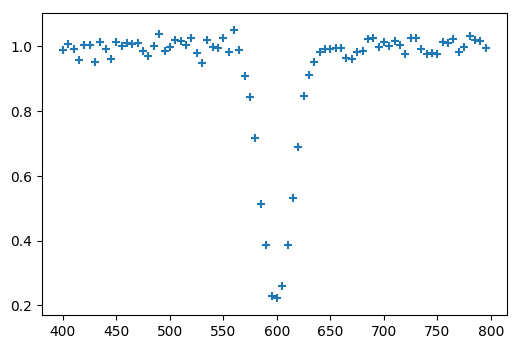

In [8]:
data = T_gs(λ) + np.random.randn(int(400/5))/50
plt.scatter(λ, data, marker='+')

To fit a model we need to slightly refactor the model to take the paramater in a slightly different order. 

We now "know", time and $\lambda$ and will be searching for the other ones

In [9]:
FitModel = lambda Af,σf: (lambda λ : T_g(λ, Af, λ0_g, σf, 0))

Note that here  $\lambda_c$ is not a fit parameter, and time is set to 0

Let's define a distance function:

In [10]:
def distance(params, data, λ):
    return np.sum((FitModel(*params)(λ)-data)**2)

We know the true parameter:

In [11]:
A0_g, σ0_g

(0.8, 20)

the distance fuction should be minimal for this value:

In [12]:
distance((0.8,20), data, λ)

0.035182838557468121

In [13]:
distance((0.7,23), data, λ)

0.076410260125224144

great, let's "fix" $\lambda$ and data and optimize.

In [14]:
import scipy.optimize as opt

In [15]:
guess = (0.3,53)

In [16]:
res = opt.fmin( lambda x:distance(x, data, λ), guess)
res

Optimization terminated successfully.
         Current function value: 0.035167
         Iterations: 55
         Function evaluations: 103


array([  0.79784131,  20.04104009])

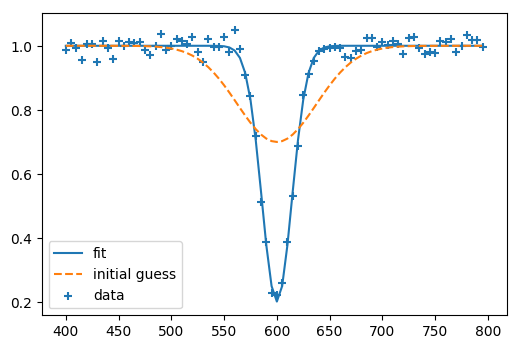

In [17]:
fig, ax = plt.subplots()
ax.plot(λ, FitModel(*res)(λ),label='fit')
ax.plot(λ, FitModel(*guess)(λ),label='initial guess', linestyle='--')
ax.scatter(λ, data, marker='+', label='data')
ax.legend()

Great !

let's change absobtion of A0 specie through time, let's make it linear (for now)

In [18]:
time = np.arange(10)
time = time.reshape((1,-1)) # -1 is a magic value that will be autocomputed.

Note that we reshape to be sure `time` and `waevelenght` are orthogonal

In [19]:
A0 = lambda t:0.8-0.1*t
A0(time)

array([[ 0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,  0.1,  0. , -0.1]])

In [20]:
T_gtime = lambda λ,t: T_g(λ, A0, λ0_g, σ0_g, t)

In [21]:
λ = λ.reshape(-1,1)

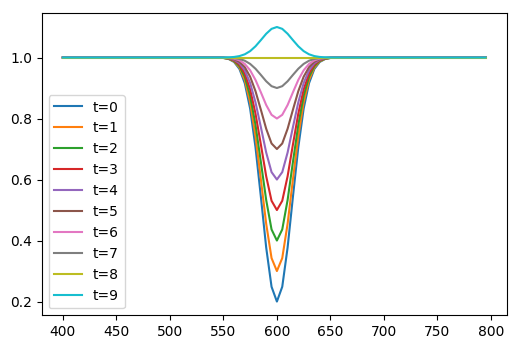

In [22]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(λ, T_gtime(λ, i), label='t={}'.format(i))
ax.legend()

Great out model change with time, we even have non-sensical values.. but it's fine for the principle. Note that because the variable $\lambda$ and time use different axis, we don't need to loop:

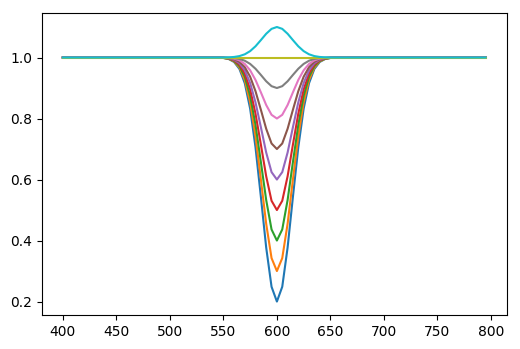

In [23]:
fig, ax = plt.subplots()
ax.plot(λ, T_gtime(λ, time))

And we can visualize in 3d.

In [24]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

let make some with our data:

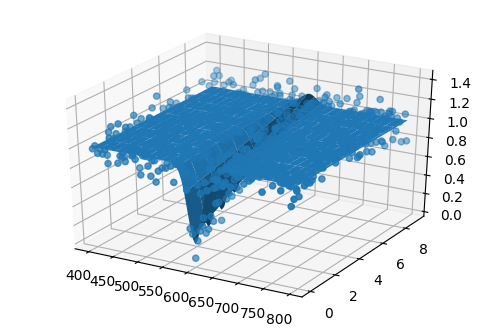

In [25]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.plot_surface(λ,time,T_gtime(λ,time), rstride=3, cstride=1)
ys = (time*λ*0+time)
xs = (time*λ*0+λ)
data = T_gtime(λ,time) + np.random.randn(*xs.shape)/10
ax.scatter(xs,ys,data)
plt.show()

Let's create our new Fit model, this Time `Af` becomes a linear function with 2 parameters:

In [26]:
FitModel = lambda Af0,Aft,σf: (lambda λ,time : T_g(λ, lambda time:Af0+Aft*time, λ0_g, σf, time))

The distance function does not change, except it will now need more parameters:

In [27]:
def distance(params, data, λ, time):
    return np.sum((FitModel(*params)(λ, time)-data)**2)

and shoudl be minimal for `(0.8,0.1, 20)`

In [28]:
distance((0.8, -0.1, 20), data, λ, time)

8.1782047767712598

In [29]:
distance((0.7, -0.1, 20), data, λ, time),\
distance((0.8, -0.2, 20), data, λ, time),\
distance((0.8, -0.1, 25), data, λ, time)

(8.697647261997556, 22.97713727102181, 8.8074483708815414)

In [30]:
guess = (0.3, 0.5, 30)

In [31]:
res = opt.fmin( lambda x:distance(x, data, λ, time), guess)
res

Optimization terminated successfully.
         Current function value: 8.145221
         Iterations: 152
         Function evaluations: 269


array([  0.80483804,  -0.09802987,  18.75145109])

In [32]:
distance(guess, data, λ, time)

604.01925189467943

In [33]:
Tres = FitModel(*res)

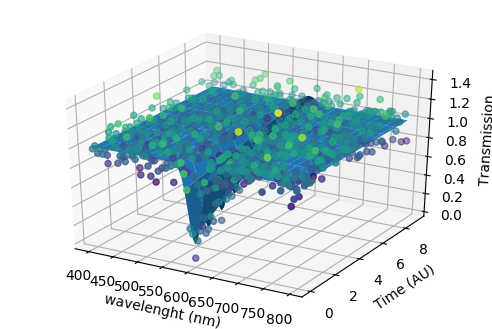

In [34]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.plot_surface(λ,time,Tres(λ,time), rstride=3, cstride=1)
ys = (time*λ*0+time)
xs = (time*λ*0+λ)
ax.scatter(xs,ys,data, c=data-T_gtime(λ,time))
ax.set_xlabel('wavelenght (nm)')
ax.set_ylabel('Time (AU)')
ax.set_zlabel('Transmission')
plt.show()

Let's look at the difference between the data and our fit:

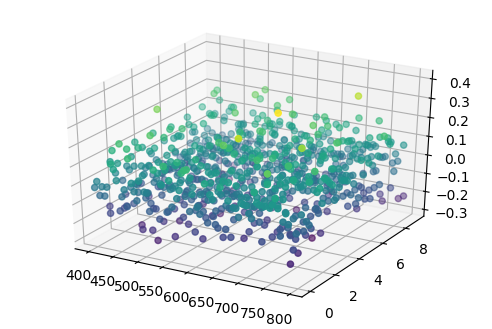

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

## get the rigth schape for scatter
ys = (time*λ*0+time)
xs = (time*λ*0+λ)

ax.scatter(xs,ys,data-Tres(λ,time), 
           # color  wit respect to distance from 0
           c=(data-Tres(λ,time)))
plt.show()